# Predicting Student Performance From Gameplay

## Business Problem

BrainBoost Interactive is a growing company with a mission to create educational games that dynamically update based on predicted student performance. Their mission requires that they develop the ability to predict test performance based on student’s interactions with their games. Here, I develop a classification model that BrainBoost Interactive can use to determine whether students will pass an evaluation interspersed throughout the choose-your-own adventure detective game: Jo Wilder and the Capitol Case. 

![](figs/jowilder.png)

## Dataset & Methods

The training and validation data for this model were sourced from game plays hosted on the [PBS Wisconsin Education website](https://pbswisconsineducation.org/jowilder/play-the-game/). The data has been aggregated and is [available on Kaggle](https://www.kaggle.com/competitions/predict-student-performance-from-game-play/overview).

## Import and Explore Data

In [26]:
# Import packages
import math
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Import data from csv files
data = pd.read_csv('/Users/tem/Documents/Flatiron/projects/train.csv')
labels = pd.read_csv('/Users/tem/Documents/Flatiron/projects/train_labels.csv')

In [66]:
# Preview data
data.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [65]:
# Check for number of participants in study
subs = data['session_id'].unique()
subs

23562

In [69]:
# Check if number of participants * number of questions == number of labels 
(subs * 18) == labels.shape[0]

True

In [25]:
# Create target (y)
labels['session_id'] = labels['session_id'].apply(lambda x: str(x).split('_')[0])
lab_per_sub = labels.groupby('session_id', as_index=False).sum()
med_correct = lab_per_sub['correct'].median()
lab_per_sub['pass'] = (lab_per_sub['correct'] > med_correct).astype(int)
lab_per_sub

,session_id,correct,pass
0,20090312431273200,16,1
1,20090312433251036,10,0
2,20090312455206810,17,1
3,20090313091715820,12,0
4,20090313571836404,16,1
...,...,...,...
23557,22100215342220508,16,1
23558,22100215460321130,12,0
23559,22100217104993650,15,1
23560,22100219442786200,13,0


In [103]:
# Explore available features
data.columns

Index(['session_id', 'elapsed_time', 'room_coor_x', 'room_coor_y',
       'screen_coor_x', 'screen_coor_y', 'event_name', 'hover_duration',
       'level_group', 'level'],
      dtype='object')

Examination of the dataset reveals that it is structured as a time series. Each participant has multiple rows corresponding to data from 1 out of the 22 levels. To make the data more interpretable, I will aggregate over the 22 levels to derive a single value for each feature per level. 

Specifically:

- I will sum the values for the following columns: 'time', 'cutscene_clicks', 'person_clicks', 'navigate_clicks', 'observation_clicks', 'notification_clicks', 'object_hovers', and 'map_hovers'.
- I will compute the standard deviation for 'room_coor_x' and 'room_coor_y'. This provides insight into the player's exploration behavior within the game spaces.

## Feature Engineering

In [87]:
# Filter dataframe for relevant features 
rel_cols = ['session_id', 'elapsed_time', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'event_name', 'hover_duration', 'level_group', 'level']
data = data[rel_cols]
subs = data['session_id'].unique()
all_events = data['event_name'].unique()
levels = data['level'].unique()

In [157]:
# Feature engineering
# Create new columns for time, number of event types, room_coor_x_std, room_coor_y_std, screen_coor_x_std, screen_coor_y_std, and hover sum
proc_data = pd.DataFrame()

start_time = time.time()
proc_data = pd.DataFrame()

counter = 0 
for sub in subs:
    vals = []
    cols = []
    for level in levels:
        
        sub_df = data[(data['session_id'] == sub) & (data['level'] == level)]
        sub_events = sub_df['event_name'].value_counts()
        level_tag = '_l' + str(level)
        
        # time
        vals.extend([sub_df['elapsed_time'].max() - sub_df['elapsed_time'].min()])
        cols.append('time' + level_tag)
        
        # event counts
        vals.extend([sub_events.get(event, 0) for event in all_events])
        cols.extend([event + 's' + level_tag for event in all_events])
        
        # room_coor_x_std
        vals.append(sub_df['room_coor_x'].std())
        cols.append('room_x_std' + level_tag)
        
        # room_coor_y_std
        vals.append(sub_df['room_coor_y'].std())
        cols.append('room_y_std' + level_tag)
        
        # screen_coor_x_std
        vals.append(sub_df['screen_coor_x'].std())
        cols.append('screen_x_std' + level_tag)
        
        # screen_coor_y_std
        vals.append(sub_df['screen_coor_y'].std())
        cols.append('screen_y_std' + level_tag)
        
        # hover sum
        vals.append(sub_df['hover_duration'].sum())
        cols.append('hover_sum' + level_tag)

    # add target
    vals.extend(lab_per_sub.loc[lab_per_sub['session_id'] == str(sub), ['correct', 'pass']].values[0])
    cols.extend(['no_correct', 'pass'])

    sub_row = pd.DataFrame([vals], columns=cols)
    proc_data = pd.concat([proc_data, sub_row], ignore_index=True)

    counter += 1
    if math.log(counter, 10) % 1 == 0 or math.log(counter, 2) % 1 == 0:
        elapsed_time = time.time() - start_time  # Calculate elapsed time
        print(f"{counter}/{len(subs)} subs processed, elapsed time: {elapsed_time:.2f} seconds")

1/23562 subs processed, elapsed time: 0.98 seconds
2/23562 subs processed, elapsed time: 1.92 seconds
4/23562 subs processed, elapsed time: 3.81 seconds
8/23562 subs processed, elapsed time: 7.55 seconds
10/23562 subs processed, elapsed time: 9.43 seconds
16/23562 subs processed, elapsed time: 15.07 seconds
32/23562 subs processed, elapsed time: 30.22 seconds
64/23562 subs processed, elapsed time: 60.60 seconds
100/23562 subs processed, elapsed time: 94.81 seconds
128/23562 subs processed, elapsed time: 121.22 seconds
256/23562 subs processed, elapsed time: 242.28 seconds
512/23562 subs processed, elapsed time: 486.00 seconds
1024/23562 subs processed, elapsed time: 967.46 seconds
2048/23562 subs processed, elapsed time: 2118.59 seconds
4096/23562 subs processed, elapsed time: 4185.66 seconds
8192/23562 subs processed, elapsed time: 8087.57 seconds
10000/23562 subs processed, elapsed time: 9811.87 seconds
16384/23562 subs processed, elapsed time: 15825.73 seconds


In [209]:
# Save df 
# proc_data.to_csv('proc_data.csv', index=False)

In [210]:
proc_data = pd.read_csv('proc_data.csv') 
proc_data

,time_l0,cutscene_clicks_l0,person_clicks_l0,navigate_clicks_l0,observation_clicks_l0,notification_clicks_l0,object_clicks_l0,object_hovers_l0,map_hovers_l0,map_clicks_l0,...,map_clicks_l22,checkpoints_l22,notebook_clicks_l22,room_x_std_l22,room_y_std_l22,screen_x_std_l22,screen_y_std_l22,hover_sum_l22,no_correct,pass
0,25766,1,10,14,1,1,1,0,0,0,...,1,1,0,392.367084,141.642302,240.615461,141.146378,366.0,16,1
1,13148,4,9,8,0,1,1,0,0,0,...,1,1,4,274.548112,181.523638,223.270785,178.743224,4344.0,10,0
2,10947,8,9,13,0,1,1,0,0,0,...,1,1,2,414.822946,225.066027,421.701039,308.743529,1417.0,17,1
3,16837,3,9,15,0,1,3,0,0,0,...,1,1,0,335.941608,147.709515,242.739104,137.986824,866.0,12,0
4,37065,1,10,9,0,4,3,0,0,0,...,1,1,0,347.249268,159.762607,217.983753,158.479231,151.0,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23557,80445,1,10,17,1,4,4,1,0,0,...,1,1,0,396.514784,133.640738,234.786712,139.604083,783.0,16,1
23558,58153,1,10,11,0,4,3,0,0,0,...,1,1,0,392.481164,142.844588,265.485781,152.706254,268.0,12,0
23559,62161,1,9,11,0,4,3,0,0,0,...,1,1,0,442.404568,131.787136,235.945479,107.216121,1518.0,15,1
23560,54097,1,11,17,1,4,2,2,0,0,...,1,1,2,446.202159,190.665275,313.512208,191.030539,417.0,13,0


In [211]:
proc_data_agg = pd.DataFrame()
proc_data_agg['pass'] = proc_data['pass']

base_columns = ['time', 'cutscene_clicks', 'person_clicks', 'navigate_clicks', 'observation_clicks', 
                'notification_clicks', 'object_hovers', 'map_hovers']

for base_col in base_columns:
    level_columns = [f"{base_col}_l{i}" for i in range(23)]  
    proc_data_agg[base_col] = proc_data[level_columns].sum(axis=1)

base_columns = ['room_x_std', 'room_y_std']

for base_col in base_columns:
    level_columns = [f"{base_col}_l{i}" for i in range(23)]  
    proc_data_agg[base_col] = proc_data[level_columns].mean(axis=1)

proc_data_agg

,pass,time,cutscene_clicks,person_clicks,navigate_clicks,observation_clicks,notification_clicks,object_hovers,map_hovers,room_x_std,room_y_std
0,1,890051.0,100,249,354,8,27,38,27,385.809645,131.949266
1,0,3391907.0,112,260,801,10,28,103,219,388.854440,160.146099
2,1,1037352.0,120,215,247,4,24,24,30,407.551567,162.259614
3,0,1324637.0,112,234,416,10,28,45,39,387.713493,164.421754
4,1,963907.0,92,222,279,8,25,31,15,388.806002,142.828672
...,...,...,...,...,...,...,...,...,...,...,...
23557,1,57266837.0,99,229,308,10,29,55,27,419.341062,153.150212
23558,0,1729772.0,112,286,301,8,26,53,67,371.683254,152.793614
23559,1,1840423.0,115,269,495,9,34,52,27,425.000047,155.991117
23560,0,1024382.0,97,216,347,7,25,34,24,404.883597,166.775889


In [212]:
# View descriptive summary of aggregated data
proc_data_agg.describe()

,pass,time,cutscene_clicks,person_clicks,navigate_clicks,observation_clicks,notification_clicks,object_hovers,map_hovers,room_x_std,room_y_std
count,23562.000000,2.356200e+04,23562.000000,23562.000000,23562.000000,23562.000000,23562.000000,23562.000000,23562.000000,23562.000000,23562.000000
mean,0.455564,1.187784e+07,114.720100,256.890459,480.707622,9.012605,27.544394,44.863976,40.113700,399.884470,152.123915
std,0.498032,3.371343e+08,15.857065,35.096675,247.943250,3.726604,5.146667,20.398135,28.973146,18.525095,13.094827
min,0.000000,1.906400e+04,67.000000,200.000000,162.000000,3.000000,20.000000,0.000000,0.000000,335.091001,107.441929
25%,0.000000,1.223696e+06,103.000000,229.000000,329.000000,6.000000,24.000000,35.000000,24.000000,386.926607,142.672346
50%,0.000000,1.603128e+06,114.000000,257.000000,418.000000,8.000000,26.000000,44.000000,34.000000,399.448987,150.859760
75%,1.000000,2.291326e+06,122.000000,274.000000,556.000000,11.000000,30.000000,55.000000,50.000000,412.373698,160.475638
max,1.000000,4.345666e+10,483.000000,917.000000,11493.000000,78.000000,114.000000,232.000000,472.000000,489.536239,216.221627


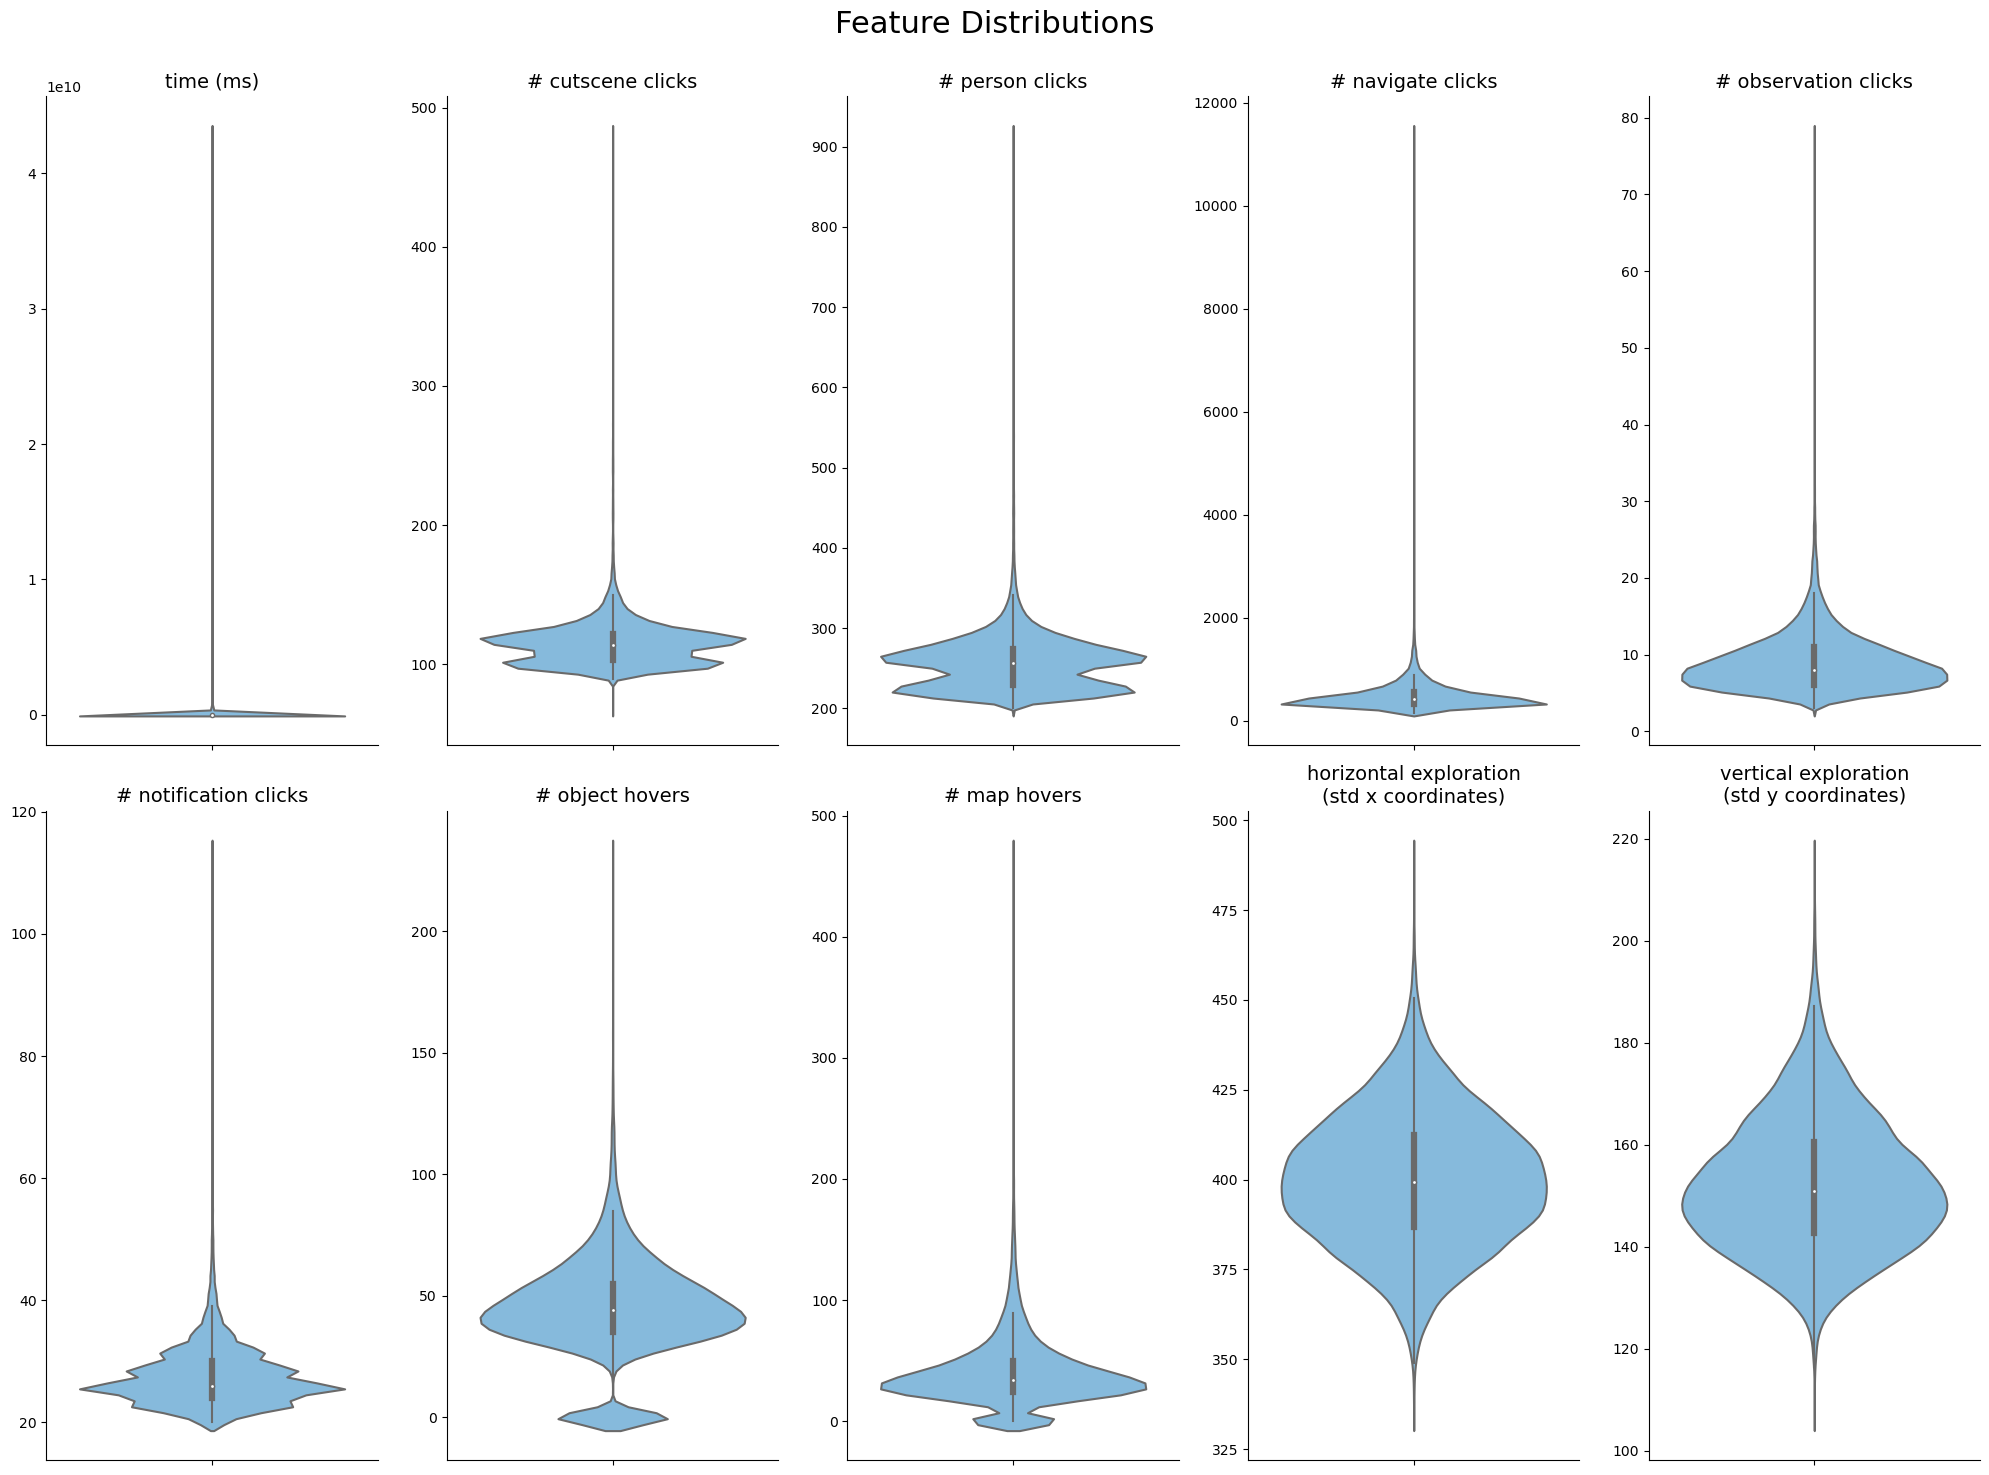

In [213]:
# Plot the distribution of each feature
labels = ['time (ms)', '# cutscene clicks', '# person clicks', '# navigate clicks',
       '# observation clicks', '# notification clicks', '# object hovers',
       '# map hovers', 'horizontal exploration\n(std x coordinates)', 'vertical exploration\n(std y coordinates)']

label_no = 0
df_vis =  proc_data_agg.drop(['pass'], axis=1)

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 15))

axes = axes.flatten()

for ax, column in zip(axes, df_vis.columns):
    sns.violinplot(y=df_vis[column], ax=ax, color='#78BDEA')
    
    # Set title for the subplot
    ax.set_title(labels[label_no], fontsize=14)
    ax.set_ylabel("")
    label_no += 1
    sns.despine()
fig.suptitle('Feature Distributions\n', fontsize=22)
plt.tight_layout()

plt.savefig("figs/feature_violins.png", dpi=300)

The above violin plots show that most players engaged minimally in terms of time spent and actions like clicks or hovers. However, there are notable outliers in features such as time, number of cutscene clicks, and number of person clicks. Additionally, exploration, both horizontal and vertical, displays a concentrated distribution, indicating players had specific areas of interest or movement within the game space.

## Preparation for Modeling

Prior to modeling, it is essential to assess the presence of collinearity (where two features are highly correlated) and multicollinearity (where one feature can be linearly predicted from others). To do this, I'll examine pairwise correlations among the features and compute the variance inflation factor (VIF) for each one.

In [214]:
# Create X and y variables
X = proc_data_agg.drop(['pass'], axis=1)
y = proc_data_agg['pass']

# Split training data into training, validation, and testing datasets 
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.3, random_state=42)
X_validate, X_test, y_validate, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_validate = pd.DataFrame(scaler.transform(X_validate), columns=X_validate.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print(f"X_train shape = {X_train.shape}")
print(f"X_validate shape = {X_validate.shape}")
print(f"X_test shape = {X_test.shape}")
print("----------------------------")
print(f"y_train shape = {y_train.shape}")
print(f"y_validate shape = {y_validate.shape}")
print(f"y_test shape = {y_test.shape}")

X_train shape = (16493, 10)
X_validate shape = (3534, 10)
X_test shape = (3535, 10)
----------------------------
y_train shape = (16493,)
y_validate shape = (3534,)
y_test shape = (3535,)


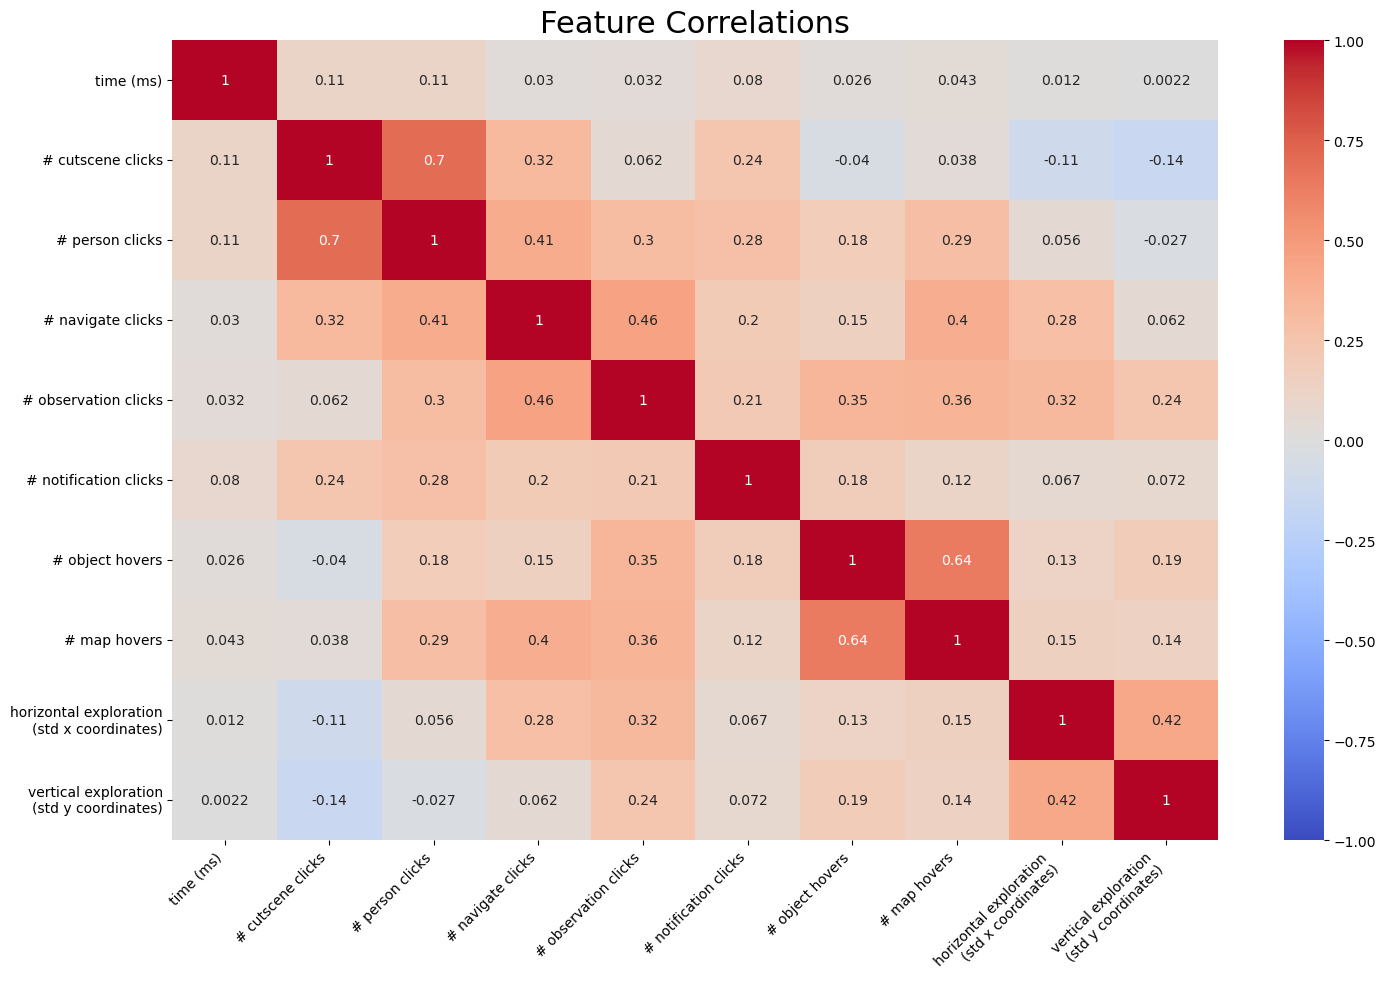

In [215]:
# Create a heatmap of feature correlations
plt.figure(figsize=(15, 10))
ax = sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels)
plt.title('Feature Correlations', fontsize=22)
plt.tight_layout()
plt.savefig('figs/feature-corrs.png', dpi=300)

The correlation heatmap reveals that most of the features are not significantly correlated with each other, underscoring the independence of each feature. Most correlation values are below 0.4, and all are below the standard threshold of 0.7, indicating that no correlation value is excessively high.

To further validate the absence of multicollinearity, I next calculated the Variance Inflation Factor (VIF) for each feature. 

In [216]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif_data

,Feature,VIF
0,time,1.019295
1,cutscene_clicks,2.368058
2,person_clicks,2.512313
3,navigate_clicks,1.721397
4,observation_clicks,1.571188
5,notification_clicks,1.144622
6,object_hovers,1.896426
7,map_hovers,2.100403
8,room_x_std,1.398405
9,room_y_std,1.283534


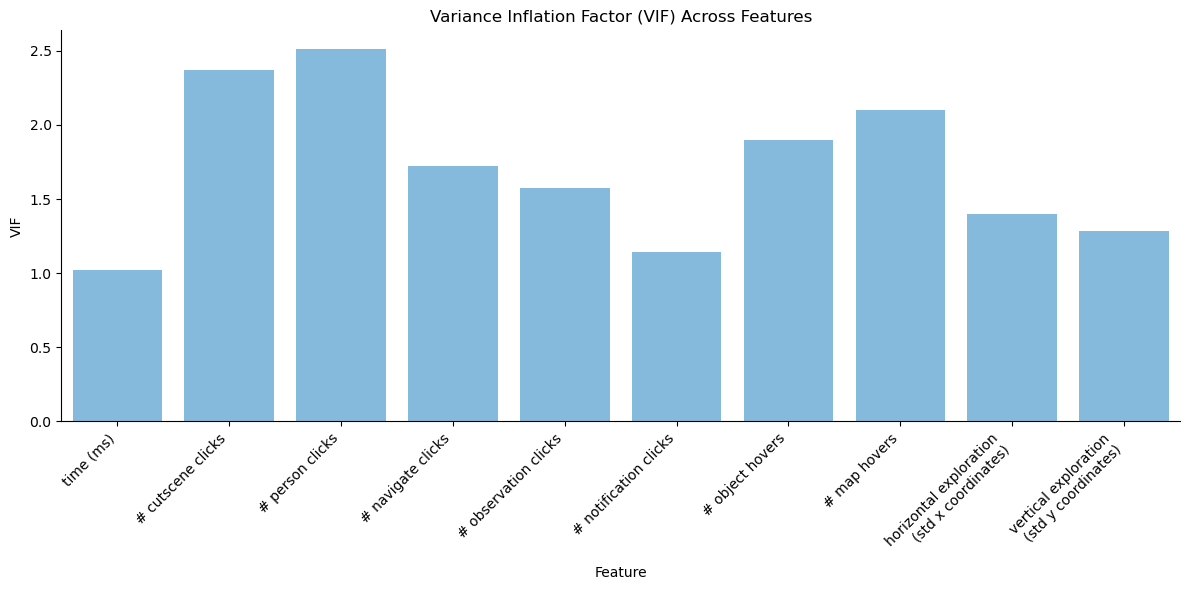

In [217]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Feature', y='VIF', data=vif_data, color='#78BDEA')

ax.set_xticklabels(labels, rotation=45, ha='right')

plt.title('Variance Inflation Factor (VIF) Across Features')
sns.despine()
plt.tight_layout()
plt.savefig('figs/feature-VIF.png', dpi=300)

All VIF values are well below the standard threshold of 5, with the highest being cutscene_clicks at approximately 2.13. These low VIF values reinforce confidence in the independence of the features. Because of this, I will feed all 10 features into the baseline models. 

## Baseline Model Comparison

I will fit two baseline models for this binary classification problem: logistic regression and decision tree. Model performance will be gauged using accuracy, as it is crucial to accurately identify students whether they pass or fail the test. This will help the game adjust dynamically both for students who are doing well and need more of a challenge and for students who are not doing well and need assistance. As a secondary test, I will also look at F1 scores for the baseline models.

In [218]:
# Fit baseline logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Calculate accuracy and F1 of training data
y_pred_train = logreg.predict(X_train)
print(f"accuracy training = {accuracy_score(y_train, y_pred_train)}")
print(f"f1 training = {f1_score(y_train, y_pred_train)}")
print("-------------------------------------------------")

# Calculate accuracy and F1 of validation data
y_pred_validate = logreg.predict(X_validate)
print(f"accuracy validation = {accuracy_score(y_validate, y_pred_validate)}")
print(f"f1 validation = {f1_score(y_validate, y_pred_validate)}")

# ROC curves
# Training data
y_prob_train_logreg = logreg.predict_proba(X_train)[:,1]
fpr_train_logreg, tpr_train_logreg, _ = roc_curve(y_train, y_prob_train_logreg)
roc_auc_train_logreg = auc(fpr_train_logreg, tpr_train_logreg)

# Validation data
y_prob_validate_logreg = logreg.predict_proba(X_validate)[:,1]
fpr_validate_logreg, tpr_validate_logreg, _ = roc_curve(y_validate, y_prob_validate_logreg)
roc_auc_validate_logreg = auc(fpr_validate_logreg, tpr_validate_logreg)

accuracy training = 0.6592493785242224
f1 training = 0.6392811296534018
-------------------------------------------------
accuracy validation = 0.666383701188455
f1 validation = 0.6426189754471052


In [219]:
# Fit baseline decision tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Calculate accuracy and F1 of training data
y_pred_train = dt.predict(X_train)
print(f"accuracy training = {accuracy_score(y_train, y_pred_train)}")
print(f"f1 training = {f1_score(y_train, y_pred_train)}")
print("-------------------------------------------------")

# Calculate accuracy and F1 of validation data
y_pred_validate = dt.predict(X_validate)
print(f"accuracy validation = {accuracy_score(y_validate, y_pred_validate)}")
print(f"f1 validation = {f1_score(y_validate, y_pred_validate)}")

# ROC curves
# Training data
y_prob_train_dt = dt.predict_proba(X_train)[:,1]
fpr_train_dt, tpr_train_dt, _ = roc_curve(y_train, y_prob_train_dt)
roc_auc_train_dt = auc(fpr_train_dt, tpr_train_dt)

# Validation data
y_prob_validate_dt = dt.predict_proba(X_validate)[:,1]
fpr_validate_dt, tpr_validate_dt, _ = roc_curve(y_validate, y_prob_validate_dt)
roc_auc_validate_dt = auc(fpr_validate_dt, tpr_validate_dt)

accuracy training = 1.0
f1 training = 1.0
-------------------------------------------------
accuracy validation = 0.5973401245048104
f1 validation = 0.5498260044289781


Next, I visualize the performance of the baseline models using confusion matrices and receiver operating characteristic (ROC) curves.

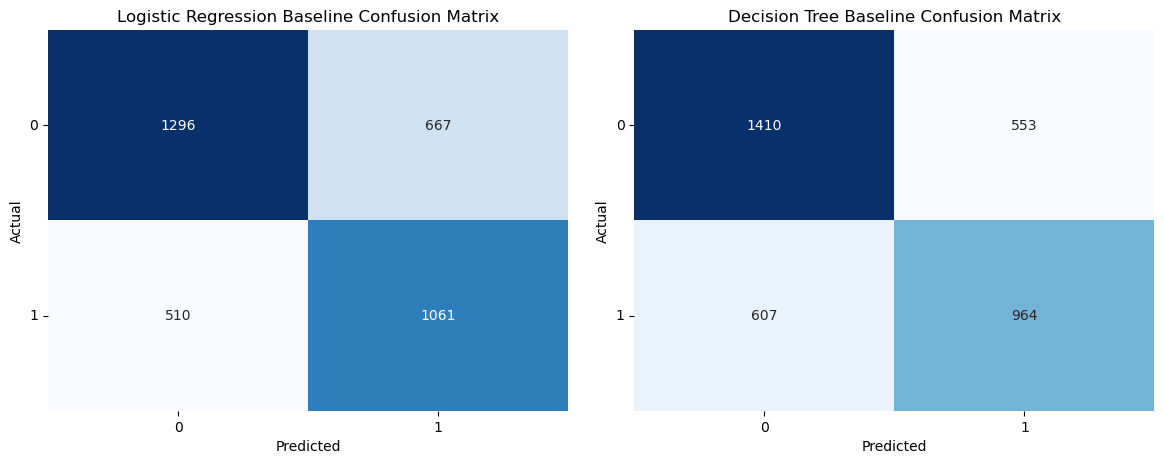

In [242]:
# Visualize baseline model performance using confusion matrix

# Predicted classes for both models
y_pred_validate_logreg = logreg.predict(X_validate)
y_pred_validate_dt = dt.predict(X_validate)

# Confusion matrices
cm_logreg = confusion_matrix(y_validate, y_pred_validate_logreg)
cm_dt = confusion_matrix(y_validate, y_pred_validate_dt)

plt.figure(figsize=(12, 5))

# Plot for Logistic Regression
plt.subplot(1, 2, 1)
sns.heatmap(cm_logreg, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0) 
plt.title('Logistic Regression Baseline Confusion Matrix')

# Plot for Decision Tree
plt.subplot(1, 2, 2)
sns.heatmap(cm_dt, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0) 
plt.title('Decision Tree Baseline Confusion Matrix')

plt.subplots_adjust(wspace=0.3) 
plt.tight_layout(pad=2)
plt.savefig('figs/baseline-confusion.png', dpi=300)

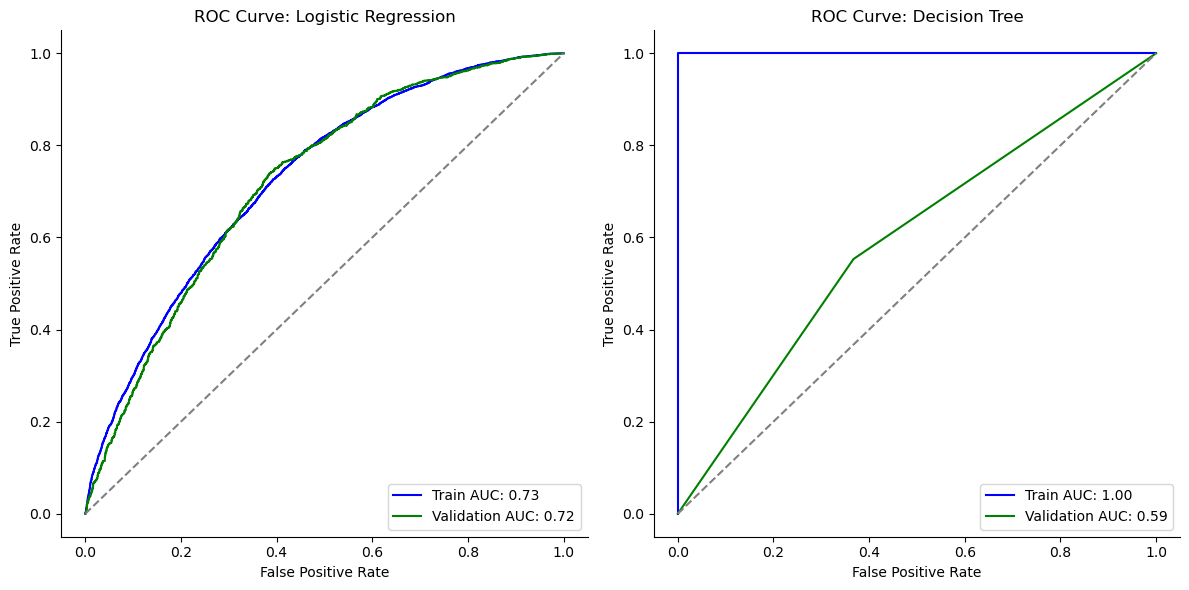

In [243]:
# Visualize baseline model performance using confusion matrix using ROC curve
plt.figure(figsize=(12, 6))
# Logistic Regression ROC
plt.subplot(1, 2, 1)
plt.plot(fpr_train_logreg, tpr_train_logreg, color='blue', label=f'Train AUC: {roc_auc_train_logreg:.2f}')
plt.plot(fpr_validate_logreg, tpr_validate_logreg, color='green', label=f'Validation AUC: {roc_auc_validate_logreg:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic Regression')
plt.legend(loc='lower right')

# Decision Tree ROC
plt.subplot(1, 2, 2)
plt.plot(fpr_train_dt, tpr_train_dt, color='blue', label=f'Train AUC: {roc_auc_train_dt:.2f}')
plt.plot(fpr_validate_dt, tpr_validate_dt, color='green', label=f'Validation AUC: {roc_auc_validate_dt:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Decision Tree')
plt.legend(loc='lower right')

plt.tight_layout()
sns.despine()
plt.savefig('figs/baseline-rocs.png', dpi=300)

The logistic regression outperforms random chance (with an accuracy above 0.50) and exhibits consistent performance across both the training and validation datasets. This is encouraging as it suggests the model is not overfitting. However, it might be underfitting, indicating a potential need for model tuning.

The decision tree appears less promising. It shows signs of overfitting, demonstrated by perfect accuracy and F1 scores on the training dataset, while its scores are close to chance on the validation dataset. 

The AUC curves provides further confidence in the logistic regression model. An AUC of 0.72 suggests that there is a 72% chance that the logistic regression model will correctly differentiate between passing and failing students. The fact that the training and validation curves nearly overlap suggests a balanced model that is not overfitting or underfitting significantly. The perfect AUC of 1.00 on the training data contrasted with a subpar AUC of 0.58 on the validation data emphasizes its overfitting nature and poor generalization to new, unseen data.

Moving forward, I will prioritize the logistic regression model and work to improve its performance through hyperparameter selection and tuning.

Specifically, I will determine which solver, which regularization strength, and tolerance level leads to the best performance in the logistic regression model. 

## Hyperparameter Selection & Tuning

In [222]:
# Select solver
training_accuracies = []
validation_accuracies = []

solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']

for solver in solvers:
    logreg = LogisticRegression(solver=solver)
    logreg.fit(X_train, y_train)
    
    # Calculate accuracy of training data
    print(solver)
    y_pred_train = logreg.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred_train)
    training_accuracies.append(accuracy)
    print(f"accuracy training = {accuracy}")
    
    # Calculate accuracy of validation data
    y_pred_validate = logreg.predict(X_validate)
    accuracy = accuracy_score(y_validate, y_pred_validate)
    validation_accuracies.append(accuracy)
    print(f"accuracy validation = {accuracy}")
    print("-------------------------------------------------")

lbfgs
accuracy training = 0.6592493785242224
accuracy validation = 0.666383701188455
-------------------------------------------------
liblinear
accuracy training = 0.6592493785242224
accuracy validation = 0.666383701188455
-------------------------------------------------
newton-cg
accuracy training = 0.6592493785242224
accuracy validation = 0.666383701188455
-------------------------------------------------
newton-cholesky
accuracy training = 0.6593100103074031
accuracy validation = 0.666383701188455
-------------------------------------------------
sag
accuracy training = 0.6593100103074031
accuracy validation = 0.666383701188455
-------------------------------------------------
saga
accuracy training = 0.6593100103074031
accuracy validation = 0.666383701188455
-------------------------------------------------


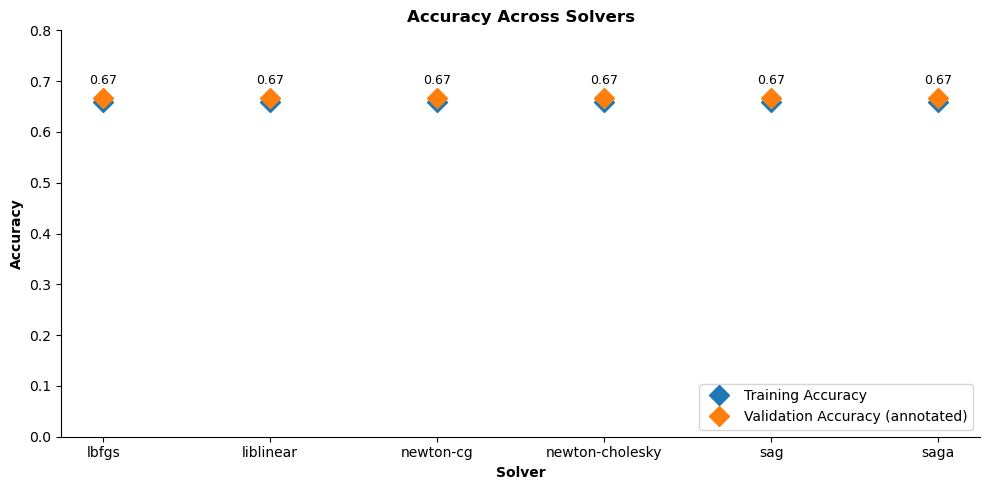

In [223]:
plt.figure(figsize=(10,5))

# Plotting training and validation accuracies
plt.plot(solvers, training_accuracies, marker='D', linestyle='', markersize=10, label='Training Accuracy')
plt.plot(solvers, validation_accuracies, marker='D', linestyle='', markersize=10, label='Validation Accuracy (annotated)')

plt.title('Accuracy Across Solvers', fontweight='bold')
plt.xlabel('Solver', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.ylim(0, 0.8) 
plt.legend(loc='lower right')

for x, y in zip(solvers, validation_accuracies):
    plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    
plt.tight_layout()
sns.despine()
plt.savefig('figs/solver-accuracy.png', dpi=300)

The choice of solver does not appear to be a major contributor to model performance, as each solver gives nearly identical accuracy scores. I will use the default solver going forward.

In [224]:
# Select penalty
training_accuracies = []
validation_accuracies = []

C_vals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1e3]

for C in C_vals:
    logreg = LogisticRegression(C=C, random_state=42)
    logreg.fit(X_train, y_train)
    
    # Calculate accuracy of training data
    print(f"C = {C}")
    y_pred_train = logreg.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred_train)
    training_accuracies.append(accuracy)
    print(f"accuracy training = {accuracy}")
    
    # Calculate accuracy of validation data
    y_pred_validate = logreg.predict(X_validate)
    accuracy = accuracy_score(y_validate, y_pred_validate)
    validation_accuracies.append(accuracy)
    print(f"accuracy validation = {accuracy}")
    print("-------------------------------------------------")

C = 0.0001
accuracy training = 0.6489419753834961
accuracy validation = 0.6406338426711942
-------------------------------------------------
C = 0.001
accuracy training = 0.6601588552719335
accuracy validation = 0.6578947368421053
-------------------------------------------------
C = 0.01
accuracy training = 0.6593100103074031
accuracy validation = 0.6677985285795133
-------------------------------------------------
C = 0.1
accuracy training = 0.6592493785242224
accuracy validation = 0.6669496321448783
-------------------------------------------------
C = 1
accuracy training = 0.6592493785242224
accuracy validation = 0.666383701188455
-------------------------------------------------
C = 10
accuracy training = 0.6591887467410417
accuracy validation = 0.666383701188455
-------------------------------------------------
C = 100
accuracy training = 0.6591887467410417
accuracy validation = 0.666383701188455
-------------------------------------------------
C = 1000.0
accuracy training = 0.6

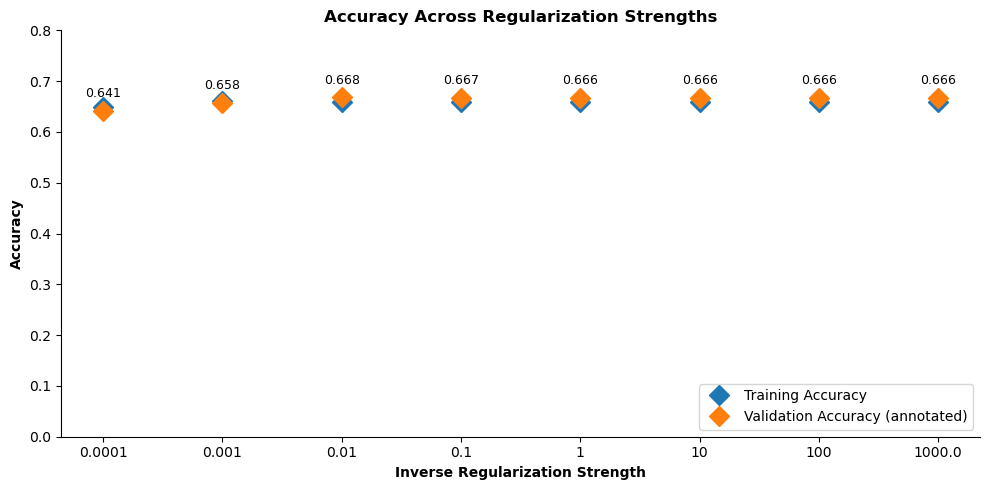

In [225]:
plt.figure(figsize=(10,5))

C_labs = [str(x) for x in C_vals]
# Plotting training and validation accuracies
plt.plot(C_labs, training_accuracies, marker='D', linestyle='', markersize=10, label='Training Accuracy')
plt.plot(C_labs, validation_accuracies, marker='D', linestyle='', markersize=10, label='Validation Accuracy (annotated)')

# Title, labels, and legend
plt.title('Accuracy Across Regularization Strengths', fontweight='bold')
plt.xlabel('Inverse Regularization Strength', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.ylim(0, 0.8) 
plt.legend(loc='lower right')

for x, y in zip(C_labs, validation_accuracies):
    plt.annotate(f"{y:.3f}", (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    
plt.tight_layout()
sns.despine()
plt.savefig('figs/reg1-accuracy.png', dpi=300)

Varying the inverse regularization strength makes a slight difference in accuracy scores, with C=0.01 producing the highest accuracy and C=0.01 coming in close second. To ensure I select the best inverse regularization strength, I will examine C values between 0.01 and 0.1. 

In [240]:
# Select penalty

training_accuracies = []
validation_accuracies = []

C_vals = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, .08, .09, 0.1]

for C in C_vals:
    logreg = LogisticRegression(C=C, random_state=42)
    logreg.fit(X_train, y_train)
    
    # Calculate accuracy of training data
    print(f"C = {C}")
    y_pred_train = logreg.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred_train)
    training_accuracies.append(accuracy)
    print(f"accuracy training = {accuracy}")
    
    # Calculate accuracy of validation data
    y_pred_validate = logreg.predict(X_validate)
    accuracy = accuracy_score(y_validate, y_pred_validate)
    validation_accuracies.append(accuracy)
    print(f"accuracy validation = {accuracy}")
    print("-------------------------------------------------")

C = 0.01
accuracy training = 0.6593100103074031
accuracy validation = 0.6677985285795133
-------------------------------------------------
C = 0.02
accuracy training = 0.6594312738737647
accuracy validation = 0.6677985285795133
-------------------------------------------------
C = 0.03
accuracy training = 0.6593100103074031
accuracy validation = 0.6677985285795133
-------------------------------------------------
C = 0.04
accuracy training = 0.6591281149578609
accuracy validation = 0.6686474250141483
-------------------------------------------------
C = 0.05
accuracy training = 0.6593100103074031
accuracy validation = 0.668081494057725
-------------------------------------------------
C = 0.06
accuracy training = 0.6593706420905839
accuracy validation = 0.6683644595359366
-------------------------------------------------
C = 0.07
accuracy training = 0.6593100103074031
accuracy validation = 0.6683644595359366
-------------------------------------------------
C = 0.08
accuracy training =

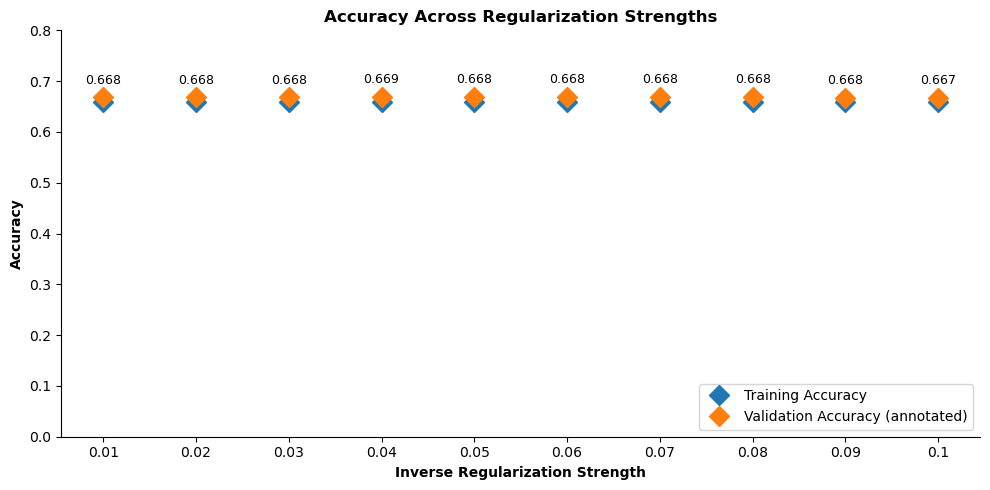

In [241]:
plt.figure(figsize=(10,5))

C_labs = [str(x) for x in C_vals]
# Plotting training and validation accuracies
plt.plot(C_labs, training_accuracies, marker='D', linestyle='', markersize=10, label='Training Accuracy')
plt.plot(C_labs, validation_accuracies, marker='D', linestyle='', markersize=10, label='Validation Accuracy (annotated)')

# Title, labels, and legend
plt.title('Accuracy Across Regularization Strengths', fontweight='bold')
plt.xlabel('Inverse Regularization Strength', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.ylim(0, 0.8) 
plt.legend(loc='lower right')

for x, y in zip(C_labs, validation_accuracies):
    plt.annotate(f"{y:.3f}", (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    
plt.tight_layout()
sns.despine()
plt.savefig('figs/reg2-accuracy.png', dpi=300)

An inverse regularization strength of C=0.04 results in the model with the best accuracy scores, at accuracy = 0.669. I will use this C value for all logistic regression models going forward.

Finally, I determine whether different levels of tolerance impacts the model accuracy. 

In [228]:
# Select tolerance

training_accuracies = []
validation_accuracies = []

tols = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

for tol in tols:
    logreg = LogisticRegression(C = 0.04, tol=tol, random_state=42)
    logreg.fit(X_train, y_train)
    
    # Calculate accuracy of training data
    print(f"tol = {tol}")
    print(f"iters = {logreg.n_iter_[0]}")
    y_pred_train = logreg.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred_train)
    training_accuracies.append(accuracy)
    print(f"accuracy training = {accuracy}")
    
    # Calculate accuracy of validation data
    y_pred_validate = logreg.predict(X_validate)
    accuracy = accuracy_score(y_validate, y_pred_validate)
    validation_accuracies.append(accuracy)
    print(f"accuracy validation = {accuracy}")
    print("-------------------------------------------------")

tol = 1e-06
iters = 16
accuracy training = 0.6591281149578609
accuracy validation = 0.6686474250141483
-------------------------------------------------
tol = 1e-05
iters = 16
accuracy training = 0.6591281149578609
accuracy validation = 0.6686474250141483
-------------------------------------------------
tol = 0.0001
iters = 16
accuracy training = 0.6591281149578609
accuracy validation = 0.6686474250141483
-------------------------------------------------
tol = 0.001
iters = 16
accuracy training = 0.6591281149578609
accuracy validation = 0.6686474250141483
-------------------------------------------------
tol = 0.01
iters = 16
accuracy training = 0.6591281149578609
accuracy validation = 0.6686474250141483
-------------------------------------------------
tol = 0.1
iters = 16
accuracy training = 0.6591281149578609
accuracy validation = 0.6686474250141483
-------------------------------------------------


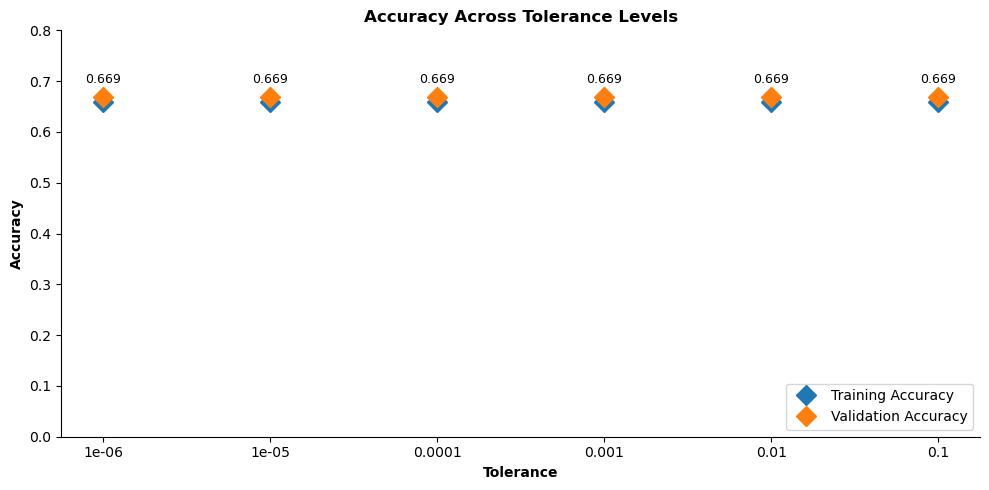

In [229]:
plt.figure(figsize=(10,5))

tol_labs = [str(x) for x in tols]
# Plotting training and validation accuracies
plt.plot(tol_labs, training_accuracies, marker='D', linestyle='', markersize=10, label='Training Accuracy')
plt.plot(tol_labs, validation_accuracies, marker='D', linestyle='', markersize=10, label='Validation Accuracy')

# Title, labels, and legend
plt.title('Accuracy Across Tolerance Levels', fontweight='bold')
plt.xlabel('Tolerance', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.ylim(0, 0.8) 
plt.legend(loc='lower right')

for x, y in zip(tol_labs, validation_accuracies):
    plt.annotate(f"{y:.3f}", (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    
plt.tight_layout()
sns.despine()
plt.savefig('figs/tolerance-accuracy.png', dpi=300)

Varying tolerance makes no impact on logistic regression model performance and the accuracy score is plateaued at accuracy = 0.669. Despite hyperparameter tuning, there is only a slight improvement from the baseline model (accuracy = 0.659). For this reason, I will revisit the initial set of features used in the model, and now explore whether incorporating polynomial versions of these features (and their interactions) can enhance the model's accuracy. I will iterate through logistic regression models trained on 1-degree, 2-degree, and 3-degree polynomial features.

In [230]:
training_accuracies = []
validation_accuracies = []

degrees = [1, 2, 3] 

for degree in degrees:
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, interaction_only=False)
    X_train_poly = poly.fit_transform(X_train)
    X_validate_poly = poly.transform(X_validate)

    # Train logistic regression model
    logreg = LogisticRegression(C = 0.04, random_state=42, max_iter=1000000) 
    logreg.fit(X_train_poly, y_train)

    # Predict and calculate accuracy for training data
    print(f"degree = {degree}")
    y_pred_train = logreg.predict(X_train_poly)
    accuracy = accuracy_score(y_train, y_pred_train)
    training_accuracies.append(accuracy)
    print(f"accuracy training = {accuracy}")
    
    # Calculate accuracy of validation data
    y_pred_validate = logreg.predict(X_validate_poly)
    accuracy = accuracy_score(y_validate, y_pred_validate)
    validation_accuracies.append(accuracy)
    print(f"accuracy validation = {accuracy}")
    print("-------------------------------------------------")

degree = 1
accuracy training = 0.6591281149578609
accuracy validation = 0.6686474250141483
-------------------------------------------------
degree = 2
accuracy training = 0.6727096343903474
accuracy validation = 0.6757215619694398
-------------------------------------------------
degree = 3
accuracy training = 0.6793791305402291
accuracy validation = 0.6709111488398415
-------------------------------------------------


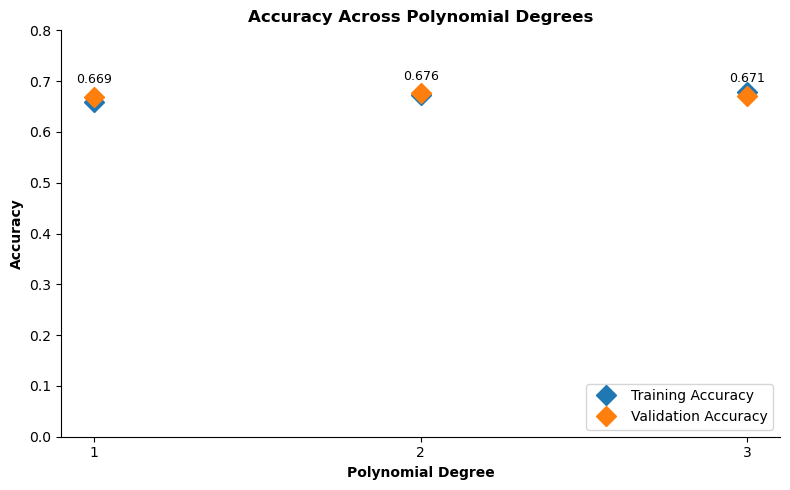

In [231]:
plt.figure(figsize=(8,5))

degrees = [str(x) for x in degrees]
# Plotting training and validation accuracies
plt.plot(degrees, training_accuracies, marker='D', linestyle='', markersize=10, label='Training Accuracy')
plt.plot(degrees, validation_accuracies, marker='D', linestyle='', markersize=10, label='Validation Accuracy')

# Title, labels, and legend
plt.title('Accuracy Across Polynomial Degrees', fontweight='bold')
plt.xlabel('Polynomial Degree', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.ylim(0, 0.8) 
plt.legend(loc='lower right')

for x, y in zip(degrees, validation_accuracies):
    plt.annotate(f"{y:.3f}", (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    
plt.tight_layout()
sns.despine()
plt.savefig('figs/polynomial-accuracy.png', dpi=300)

The model utilizing 2-degree polynomial features shows marginally better performance on the validation dataset compared to the others, so it will be used for the final model configuration. Next, I will evaluate the final model (logistic regression with C=0.04 and 2-degree polynomials) on the testing dataset. To visualize its efficacy, I'll employ both an ROC curve and a confusion matrix.

## Assess Model Performance on Testing Data

In [232]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_validate_poly = poly.transform(X_validate)
X_test_poly = poly.transform(X_test)

# Train logistic regression model
logreg = LogisticRegression(C = 0.04, random_state=42, max_iter=1000000) 
logreg.fit(X_train_poly, y_train)

# Predict and calculate accuracy for training data
y_pred_train = logreg.predict(X_train_poly)
print(f"degree = 2")
print(f"accuracy training = {accuracy_score(y_train, y_pred_train)}")

# Predict and calculate accuracy for testing data
y_pred_test = logreg.predict(X_test_poly)
print(f"accuracy testing = {accuracy_score(y_test, y_pred_test)}")

degree = 2
accuracy training = 0.6727096343903474
accuracy testing = 0.6789250353606789


## Visualize Final Model Performance on Testing Data

In [233]:
# Calculate ROC of baseline model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_baseline = logreg.predict(X_test)
y_prob_baseline = logreg.predict_proba(X_test)[:,1]
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_prob_baseline)
roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

# Calculate ROC of final model
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train_poly, y_train)
y_pred_final = logreg.predict(X_test_poly)
y_prob_final = logreg.predict_proba(X_test_poly)[:,1]
fpr_final, tpr_final, _ = roc_curve(y_test, y_prob_final)
roc_auc_final = auc(fpr_final, tpr_final)

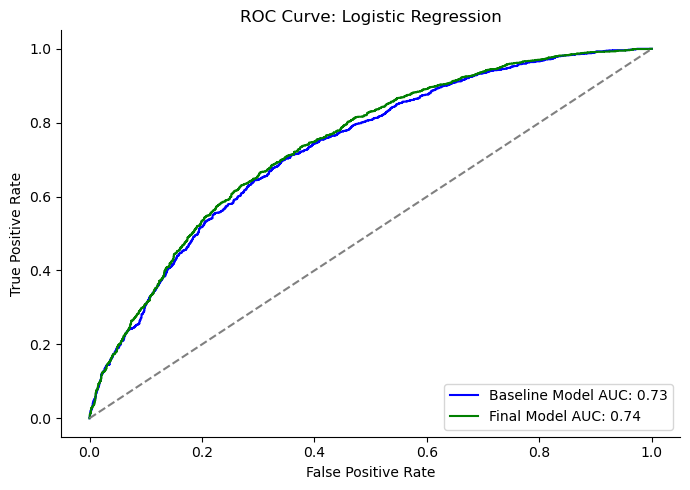

In [234]:
plt.figure(figsize=(7, 5))
# Baseline ROC
#plt.subplot(1, 2, 1)
plt.plot(fpr_baseline, tpr_baseline, color='blue', label=f'Baseline Model AUC: {roc_auc_baseline:.2f}')
plt.plot(fpr_final, tpr_final, color='green', label=f'Final Model AUC: {roc_auc_final:.2f}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic Regression')
plt.legend(loc='lower right')

plt.tight_layout()
sns.despine()
plt.savefig('figs/roc-comparison.png', dpi=300)

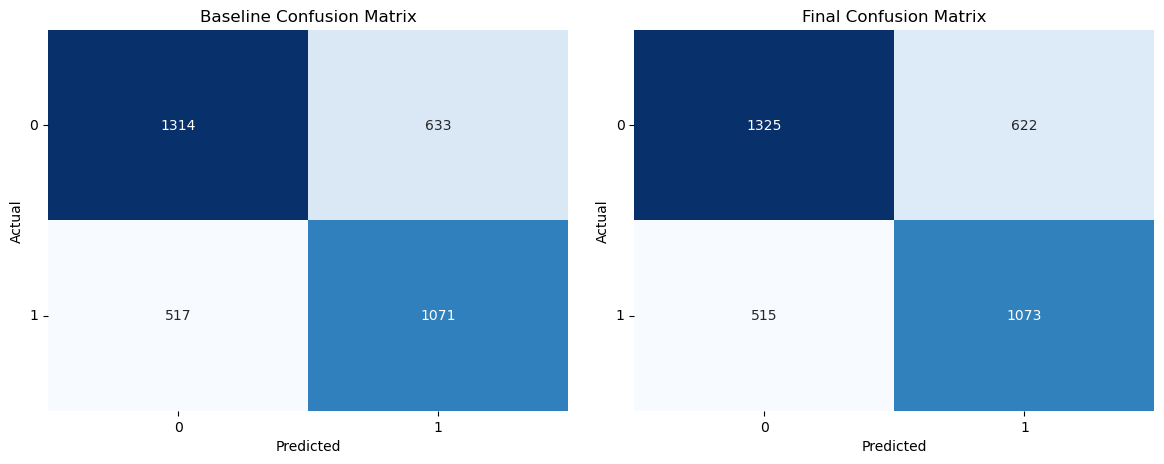

In [235]:
# Confusion matrices
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
cm_final = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(12, 5))

# Plot for Logistic Regression
plt.subplot(1, 2, 1)
sns.heatmap(cm_baseline, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0) 
plt.title('Baseline Confusion Matrix')

# Plot for Decision Tree
plt.subplot(1, 2, 2)
sns.heatmap(cm_final, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0) 
plt.title('Final Confusion Matrix')

plt.subplots_adjust(wspace=0.3) 
plt.tight_layout(pad=2)
plt.savefig('figs/confusion-comparisons.png', dpi=300)

## Conclusions and Next Steps

The objective of this project was to aid BrainBoost Interactive in predicting student performance based on their interactions with the game "Jo Wilder and the Capitol Case." We successfully constructed a logistic regression model that outperforms random chance, demonstrating the potential to utilize gameplay data for educational insights. While the model's performance is a promising start, its current accuracy might not be sufficient for real-world applications that BrainBoost Interactive envisions.

To truly harness the predictive power necessary for dynamically updating educational games, a few potential avenues could be explored:

* Time-Series Data and Modeling: The gameplay naturally has a temporal component, with students interacting with the game over time. By leveraging time series data and employing relevant modeling techniques, we might capture patterns and nuances missed by aggregate models like logistic regression.

* Incorporating Demographics: Introducing demographic variables such as age and reading level could provide more depth to the analysis. There's potential for interactions between these demographic features and gameplay metrics (like time spent on each level or number of clicks) which could offer richer insights and improve model performance.

While we have made significant strides in predicting student performance through gameplay interactions, there's room for improvement. With further refinements and the inclusion of more diverse data sources, we aspire to create a tool that's not only predictive but also instrumental in enhancing the educational experience for students using BrainBoost Interactive games.